In [253]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

## CIFAR10

In [254]:
cifar10_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [255]:
df = pd.read_csv('cifar10_decision_tree_metrics.csv', sep='\t')
df[:10]

,Index,GT Class,Pred Class,Path,Path Probs,Num Nodes Explored,Node Backtracks
0,0,3,3,"['n00003553', 'n01471682', 'n01886756', 'n0207...","[1.0, 1.0, 1.0, 1.0]",4,{}
1,1,8,8,"['n00003553', 'n03575240', 'n03125870']","[1.0, 1.0, 1.0]",3,{}
2,2,8,8,"['n00003553', 'n03575240', 'n03125870']","[1.0, 0.997, 0.9999]",3,{}
3,3,0,0,"['n00003553', 'n03575240', 'n03125870']","[0.9999, 0.9991, 0.991]",3,{}
4,4,6,6,"['n00003553', 'n01471682']","[1.0, 1.0]",2,{}
5,5,6,6,"['n00003553', 'n01471682']","[1.0, 1.0]",2,{}
6,6,1,1,"['n00003553', 'n03575240', 'n03791235']","[0.9999, 1.0, 0.9693]",3,{}
7,7,6,6,"['n00003553', 'n01471682']","[1.0, 1.0]",2,{}
8,8,3,3,"['n00003553', 'n01471682', 'n01886756', 'n0207...","[1.0, 1.0, 1.0, 1.0]",4,{}
9,9,1,1,"['n00003553', 'n03575240', 'n03791235']","[1.0, 1.0, 0.9998]",3,{}


### Preprocessing

In [256]:
def preprocess(df):
    df['Node Backtracks'] = df['Node Backtracks'].apply(lambda x: ast.literal_eval(x))
    df['Path'] = df['Path'].apply(lambda x: ast.literal_eval(x))
    df['Path Probs'] = df['Path Probs'].apply(lambda x: ast.literal_eval(x))
    df['Num Backtracks'] = df["Node Backtracks"].apply(lambda x: len(x))

## Per class stats

In [257]:
def get_class_stats(df):
    class_stats = {"Class":[], "Accuracy":[], "Avg Path Length":[], "Prop of Backtracks":[], "Target Path":[], "Num Ignored":[], 
               "Incorrect and Not Ignored":[], "Prop of Correct Backtracks":[]}
    for i in range(len(np.unique(df['GT Class']))):
        class_df = df[df['GT Class']==i]

        acc = len(class_df[class_df['Pred Class']==i])/len(class_df)
        avg_path_len = np.mean(class_df["Num Nodes Explored"])
        avg_backtracks = len(class_df[class_df['Num Backtracks']>0])/len(class_df['Num Backtracks'])
        gt_path = str(class_df[class_df['Pred Class']==i][class_df['Num Backtracks']==0]['Path'].iloc[0])
        num_ignored = len(class_df[class_df['Pred Class']==-1])
        backtrack_correct = len(class_df[class_df["Num Backtracks"]>0][class_df["Pred Class"] == i])/len(class_df[class_df["Num Backtracks"]>0])
        incorrect = class_df[class_df['Pred Class']!=i]
        incorrect_not_ignored = len(incorrect[incorrect['Num Backtracks']!=0][incorrect["Index"]!=-1])

        class_stats["Class"].append(i)
        class_stats["Accuracy"].append(acc)
        class_stats["Avg Path Length"].append(avg_path_len)
        class_stats["Prop of Backtracks"].append(avg_backtracks)

        # find unique path
        class_stats['Target Path'].append(gt_path)

        class_stats["Num Ignored"].append(num_ignored)
        class_stats["Prop of Correct Backtracks"].append(backtrack_correct)

        class_stats["Incorrect and Not Ignored"].append(incorrect_not_ignored)

    return class_stats

In [258]:
preprocess(df)
class_stats = get_class_stats(df)
stats = pd.DataFrame(class_stats)
stats[:10]

,Class,Accuracy,Avg Path Length,Prop of Backtracks,Target Path,Num Ignored,Incorrect and Not Ignored,Prop of Correct Backtracks
0,0,0.937,3.005,0.018,"['n00003553', 'n03575240', 'n03125870']",14,15,0.166667
1,1,0.968,3.007,0.005,"['n00003553', 'n03575240', 'n03791235']",4,4,0.200000
2,2,0.920,2.122,0.013,"['n00003553', 'n01471682']",1,2,0.846154
3,3,0.841,3.905,0.024,"['n00003553', 'n01471682', 'n01886756', 'n0207...",9,23,0.041667
4,4,0.929,3.942,0.010,"['n00003553', 'n01471682', 'n01886756', 'n0237...",1,9,0.100000
5,5,0.894,3.974,0.009,"['n00003553', 'n01471682', 'n01886756', 'n0207...",4,9,0.000000
6,6,0.957,2.060,0.008,"['n00003553', 'n01471682']",1,4,0.500000
7,7,0.936,3.987,0.019,"['n00003553', 'n01471682', 'n01886756', 'n0237...",8,18,0.052632
8,8,0.965,3.008,0.007,"['n00003553', 'n03575240', 'n03125870']",7,7,0.000000
9,9,0.953,3.009,0.009,"['n00003553', 'n03575240', 'n03791235']",7,7,0.222222


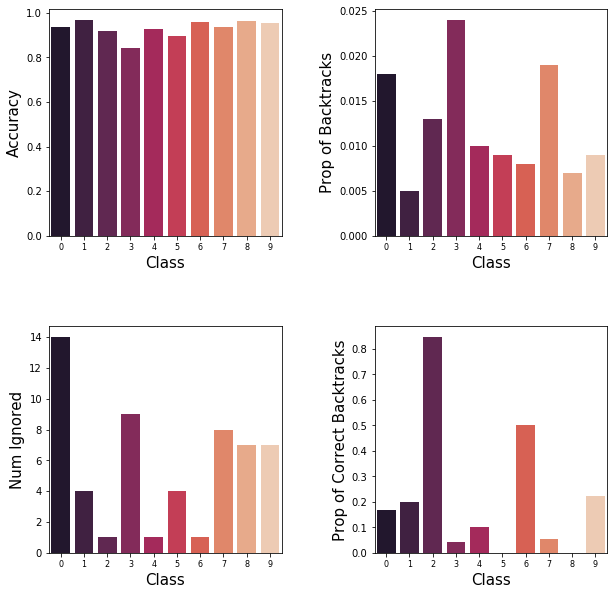

In [259]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.barplot(x='Class', y='Accuracy', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x='Class', y='Prop of Backtracks', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.barplot(x='Class', y='Num Ignored', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.barplot(x='Class', y='Prop of Correct Backtracks', data=stats, palette="rocket", ax=ax)
plt.savefig('cifar100.png')
plt.show()

## Correlations

In [333]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""

    # Compute correlation matrix
    corr_mat = np.corrcoef(list(x), list(y))

    # Return entry [0,1]
    return corr_mat[0,1]

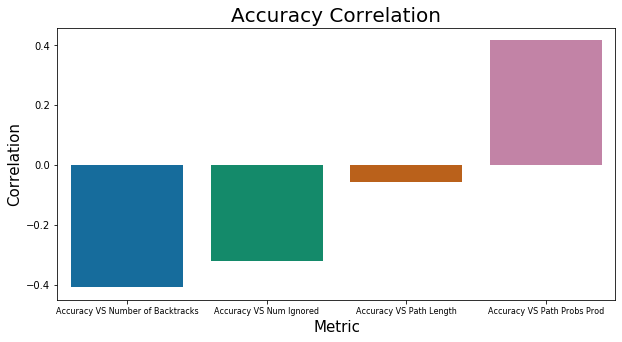

In [334]:
corr_class_stats = {"Class":[], "Correlation":[], "Metric":[]}
class_df=df
acc = class_df["GT Class"] == class_df["Pred Class"]
ignored = class_df["Pred Class"] == -1
path_probs_sum = class_df["Path Probs"].apply(lambda x: np.sum(x))
path_probs_prod = class_df["Path Probs"].apply(lambda x: np.prod(x))
path_probs_mean = class_df["Path Probs"].apply(lambda x: np.mean(x)).fillna(0)

corr_class_stats["Class"].append(class_idx)
corr_class_stats["Correlation"].append(pearson_r(acc, class_df["Num Backtracks"]))
corr_class_stats["Metric"].append("Accuracy VS Number of Backtracks")

corr_class_stats["Class"].append(class_idx)
corr_class_stats["Correlation"].append(pearson_r(acc, ignored))
corr_class_stats["Metric"].append("Accuracy VS Num Ignored")

corr_class_stats["Class"].append(class_idx)
corr_class_stats["Correlation"].append(pearson_r(acc,  class_df["Num Nodes Explored"]))
corr_class_stats["Metric"].append("Accuracy VS Path Length")

corr_class_stats["Class"].append(class_idx)
corr_class_stats["Correlation"].append(pearson_r(acc, path_probs_prod))
corr_class_stats["Metric"].append("Accuracy VS Path Probs Prod")

fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='Metric', y='Correlation', palette="colorblind", data=pd.DataFrame(corr_class_stats), ax=ax)
plt.title("Accuracy Correlation", fontsize=20)
plt.savefig('cifar10_correlation.png')
plt.show()

In [337]:
corr_class_stats = {"Class":[], "Correlation":[], "Metric":[]}
for i in range(len(np.unique(df['GT Class']))):
    acc = class_df["GT Class"] == class_df["Pred Class"]
    ignored = class_df["Pred Class"] == -1
    path_probs_sum = class_df["Path Probs"].apply(lambda x: np.sum(x))
    path_probs_prod = class_df["Path Probs"].apply(lambda x: np.prod(x))
    path_probs_mean = class_df["Path Probs"].apply(lambda x: np.mean(x)).fillna(0)
    
    corr_class_stats["Class"].append(i)
    corr_class_stats["Correlation"].append(pearson_r(acc, class_df["Num Backtracks"]))
    corr_class_stats["Metric"].append("Accuracy VS Number of Backtracks")
    
    corr_class_stats["Class"].append(i)
    corr_class_stats["Correlation"].append(pearson_r(acc, ignored))
    corr_class_stats["Metric"].append("Accuracy VS Num Ignored")

    corr_class_stats["Class"].append(i)
    corr_class_stats["Correlation"].append(pearson_r(acc,  class_df["Num Nodes Explored"]))
    corr_class_stats["Metric"].append("Accuracy VS Path Length")

    corr_class_stats["Class"].append(i)
    corr_class_stats["Correlation"].append(pearson_r(acc, path_probs_prod))
    corr_class_stats["Metric"].append("Accuracy VS Path Probs Prod")

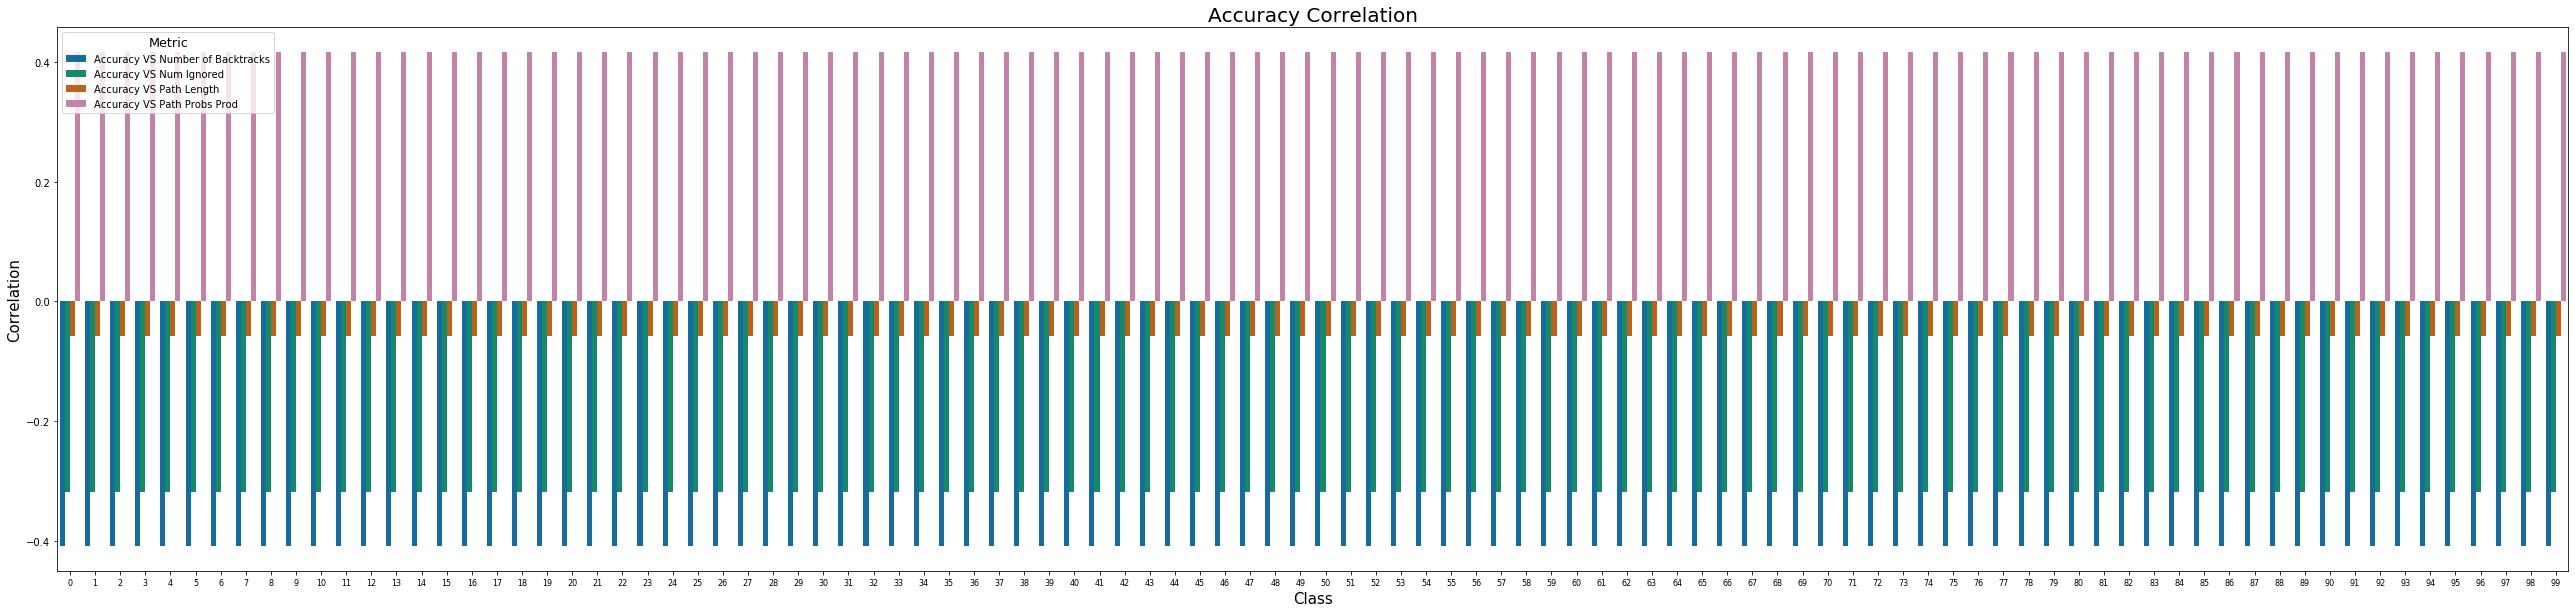

In [339]:
fig_dims = (45, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='Class', y='Correlation', hue="Metric", palette="colorblind", data=pd.DataFrame(corr_class_stats), ax=ax)
plt.title("Accuracy Correlation", fontsize=20)
plt.savefig('cifar100_class_correlation.png')
plt.show()

## CIFAR100

In [330]:
df = pd.read_csv('cifar100_decision_tree_metrics.csv', sep='\t')
df[:10]

,Index,GT Class,Pred Class,Path,Path Probs,Num Nodes Explored,Node Backtracks
0,0,49,71,"['n00001740', 'n00001930']","[1.0, 0.0012]",5,"{'n00003553': 1, 'n00002684': 1, 'n00007846': 1}"
1,1,33,33,"['n00001740', 'n00002137']","[0.9887, 0.9995]",2,{}
2,2,72,93,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 0.9787, 0.9988, 0.9884, 0.9572, 0.4903, ...",9,{'n01661818': 1}
3,3,51,91,"['n00001740', 'n00001930', 'n00020827']","[0.9994, 0.8387, 0.7647]",3,{}
4,4,71,71,"['n00001740', 'n00001930']","[1.0, 0.9999]",2,{}
5,5,92,6,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 1.0, 1.0, 1.0, 0.7812, 0.9996, 0.9997, 0...",9,{}
6,6,15,15,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 0.9896, 0.9925, 0.8971, 0.9857, 0.9956, ...",10,{}
7,7,14,65,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[0.9997, 0.9522, 0.9917, 0.9944, 0.9958, 0.481...",13,"{'n02159955': 1, 'n01767661': 1, 'n01905661': ..."
8,8,23,71,"['n00001740', 'n00001930']","[1.0, 0.9969]",2,{}
9,9,0,57,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 1.0, 1.0, 1.0, 0.9516]",5,{}


## Per class stats

In [331]:
preprocess(df)
class_stats = get_class_stats(df)
stats = pd.DataFrame(class_stats)
stats[:10]

,Class,Accuracy,Avg Path Length,Prop of Backtracks,Target Path,Num Ignored,Incorrect and Not Ignored,Prop of Correct Backtracks
0,0,0.85,5.37,0.06,"['n00001740', 'n00001930', 'n00002684', 'n0000...",5,6,0.000000
1,1,0.70,7.98,0.18,"['n00001740', 'n00001930', 'n00002684', 'n0000...",6,12,0.333333
2,2,0.57,3.81,0.11,"['n00001740', 'n00001930', 'n00007846']",3,10,0.090909
3,3,0.27,8.24,0.21,"['n00001740', 'n00001930', 'n00002684', 'n0000...",6,18,0.142857
4,4,0.60,5.33,0.17,"['n00001740', 'n00001930', 'n00020827']",9,16,0.058824
5,5,0.67,7.24,0.10,"['n00001740', 'n00001930', 'n00002684', 'n0000...",2,7,0.300000
6,6,0.70,9.11,0.18,"['n00001740', 'n00001930', 'n00002684', 'n0000...",3,13,0.277778
7,7,0.68,8.91,0.17,"['n00001740', 'n00001930', 'n00002684', 'n0000...",9,17,0.000000
8,8,0.76,8.12,0.16,"['n00001740', 'n00001930', 'n00002684', 'n0000...",11,15,0.062500
9,9,0.66,7.89,0.17,"['n00001740', 'n00001930', 'n00002684', 'n0000...",6,17,0.000000


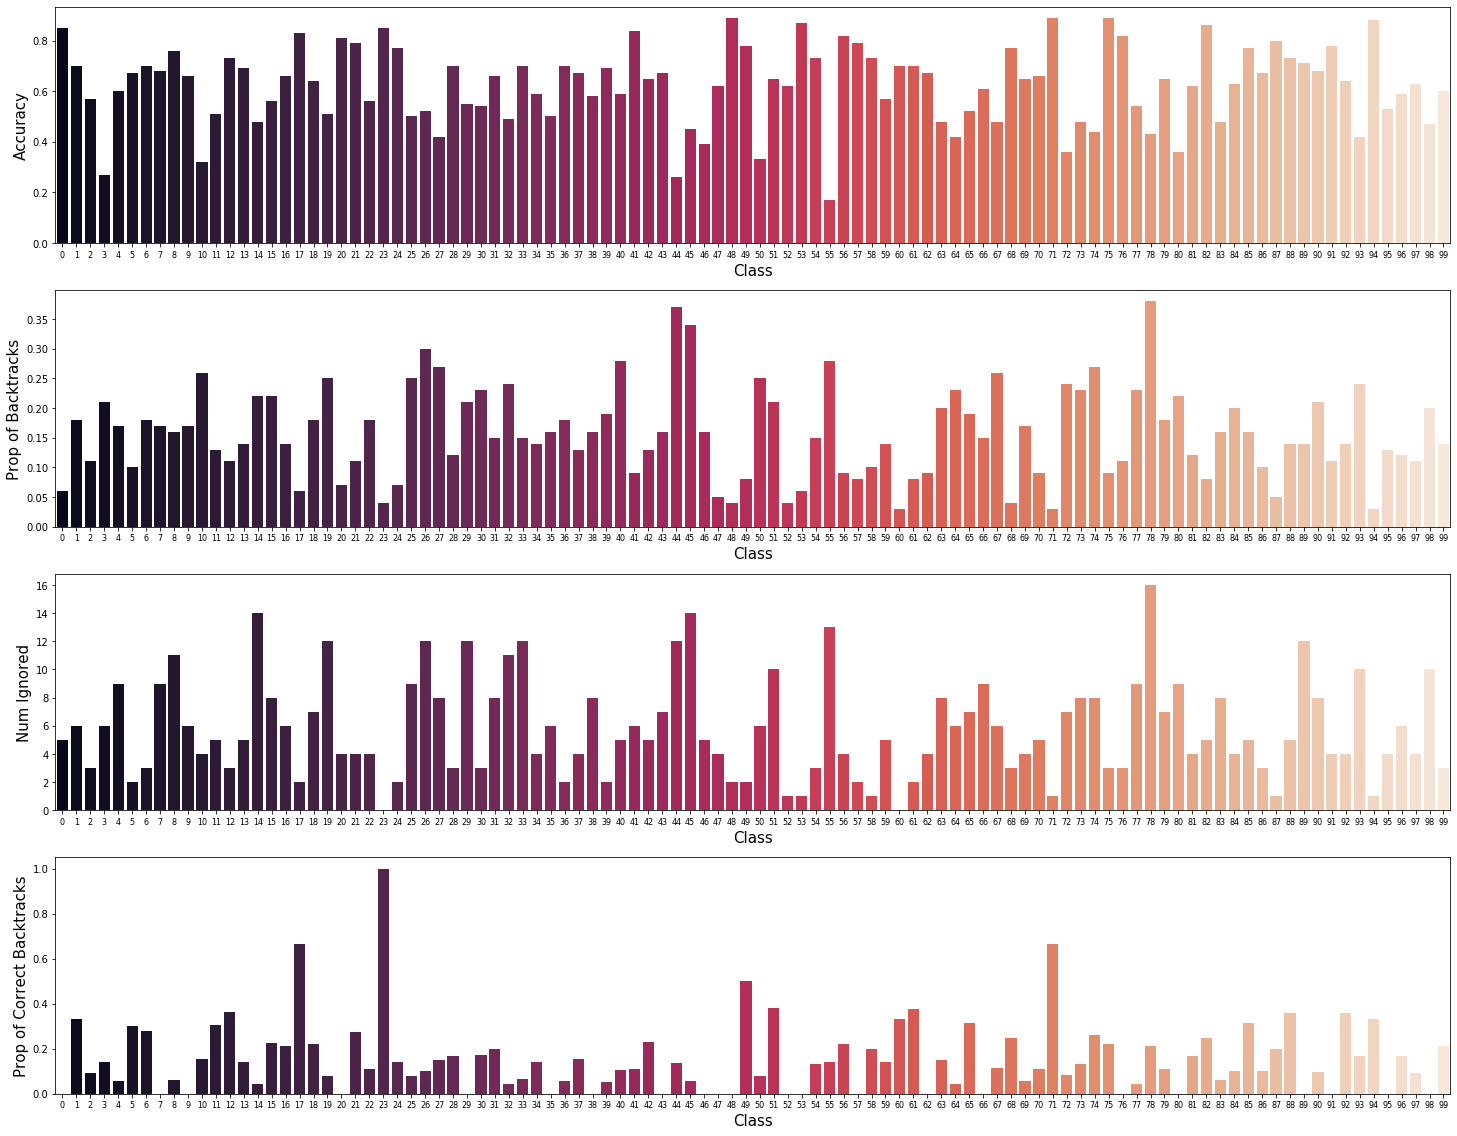

In [332]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 8 
mpl.rcParams['axes.labelsize'] = 15

fig = plt.figure(figsize=(25,20))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
ax = fig.add_subplot(4, 1, 1)
sns.barplot(x='Class', y='Accuracy', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(4, 1, 2)
sns.barplot(x='Class', y='Prop of Backtracks', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(4, 1, 3)
sns.barplot(x='Class', y='Num Ignored', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(4, 1, 4)
sns.barplot(x='Class', y='Prop of Correct Backtracks', data=stats, palette="rocket", ax=ax)
plt.savefig('cifar100.png')
plt.show()